František Šefčík a Vajk Pomichal, IAU, zimný semester 2018
# Projekt 1

#### Dataset 31

## Preprocessing

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
import json
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from functools import reduce
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import boxcox
from sklearn import cross_validation
import category_encoders as ce
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

In [48]:
pd.options.display.max_columns = None

In [49]:
other_train = pd.read_csv('31/other_train.csv')
other_valid = pd.read_csv('31/other_valid.csv')

personal_train = pd.read_csv('31/personal_train.csv')
personal_valid = pd.read_csv('31/personal_valid.csv')

## 1. Integracia dat a prípadna deduplikacia zaznamov

Na zaklade prieskumnej analyzy sme zistili ze kombinaciou 'name' a 'address' atributov dostaneme unikatny identifikator, na zaklade coho dokazeme spojit datasety.

In [50]:
result_train = pd.merge(personal_train, other_train, on=['name', 'address'])
result_test = pd.merge(personal_valid, other_valid, on=['name', 'address'])

In [51]:
result_train



,Unnamed: 0_x,name,address,age,sex,date_of_birth,Unnamed: 0_y,query hyperthyroid,FTI measured,education,lithium,TT4,T4U,capital-loss,capital-gain,tumor,TSH,T3,fnlwgt,hours-per-week,relationship,sick,workclass,TT4 measured,class,marital-status,goitre,native-country,hypopituitary,medical_info,on antithyroid medication,referral source,education-num,occupation,TBG measured,TBG,race,FTI
0,0,Edith Boudreaux,"11818 Lori Crossing Apt. 802\nPughstad, DC 78165",49.0,F,69-04-28,1425,f,t,HS-grad,f,103.0,1.11,0.0,0.0,f,8.300,0.9,108997.0,40.0,Unmarried,f,Private,t,Negative.|1379,Divorced,f,United-States,f,"{'query hypothyroid':'t','T4U measured':'t','p...",f,SVI,9.0,Adm-clerical,f,?,White,93
1,1,Janet Washington,"PSC 4657, Box 5446\nAPO AP 58412",78.0,F,1940-01-23,458,f,t,Some-college,f,112.0,0.82,0.0,0.0,f,3.100,1.1,424012.0,40.0,Not-in-family,f,Federal-gov,t,negative.|954,Divorced,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,SVHD,10.0,Exec-managerial,f,?,White,137
2,2,Margaret Chabot,Unit 9759 Box 9470\nDPO AP 45549,65.0,F,1953-06-23,1875,f,t,Masters,f,113.0,0.85,0.0,0.0,f,0.035,NaN,143046.0,40.0,Not-in-family,f,Private,t,negative.|3301,Never-married,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,other,NaN,Adm-clerical,f,?,White,133
3,3,Terry Terry,"137 Lewis Flat Suite 762\nWest Elizabeth, AL 3...",34.0,M,1984-03-08,56,t,t,Bachelors,f,99.0,0.87,0.0,0.0,f,0.080,2.1,183390.0,40.0,Not-in-family,f,Local-gov,t,Negative.|3756,Separated,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,other,NaN,Prof-specialty,f,?,White,113
4,4,Stephen Lalk,"995 Frank Stravenue\nSouth Matthewport, TX 81402",57.0,M,1961-09-16,599,f,t,Bachelors,f,164.0,1.14,0.0,0.0,f,1.600,2.1,106935.0,45.0,Husband,f,Private,t,negative.|2198,Married-civ-spouse,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",F,SVI,13.0,Exec-managerial,f,?,White,145
5,5,Colleen Satterwhite,"1781 Meredith Skyway Suite 328\nCordovaburgh, ...",59.0,F,1959-08-05,543,f,t,HS-grad,f,121.0,1.11,1721.0,0.0,f,1.400,1.1,91939.0,30.0,Not-in-family,f,Private,t,negative.|2283,Never-married,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,SVI,9.0,Adm-clerical,f,?,Black,109
6,6,Abraham Bruce,"2415 Elizabeth Knoll Suite 030\nCordovafort, C...",53.0,M,1965-10-10,2168,f,t,Doctorate,f,127.0,0.90,0.0,0.0,f,0.080,NaN,214627.0,60.0,Husband,f,Self-emp-inc,t,negative.|3276,Married-civ-spouse,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,other,16.0,Prof-specialty,f,?,White,141
7,7,James Wilson,"49824 Kim View\nWest Ericborough, VT 42457",46.0,M,1972-09-07 00 00 00,617,f,t,Some-college,f,98.0,0.94,0.0,0.0,f,0.600,NaN,183532.0,25.0,Own-child,f,Private,t,negative.|3604,Never-married,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,other,NaN,Handlers-cleaners,f,?,White,104
8,8,Judy Smith,"53231 Matthew Spur Apt. 079\nNorth Brian, MA 3...",25.0,F,1992-12-27,851,f,t,HS-grad,f,85.0,0.79,0.0,0.0,f,0.020,2.3,137310.0,40.0,Own_child,f,Private,t,negative.|2779,Never-married,f,?,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,other,9.0,Machine-op-inspct,f,?,White,107
9,9,Anna Swartz,USNV Gallegos\nFPO AA 99743,33.0,F,1985-09-05 00:00:00,57,f,t,Assoc-voc,f,NaN,0.90,0.0,0.0,f,8.200,1.5,222216.0,38.0,Unmarried,f,?,t,negative.|1117,Widowed,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,STMW,11.0,?,f,?,White,83


In [52]:
print("pred personal train (riadky,stlpce): ",personal_train.shape)
print("pred other train (riadky,stlpce): ",other_train.shape)
print("vysledny train (riadky,stlpce): ",result_train.shape)

pred personal train (riadky,stlpce):  (2237, 6)
pred other train (riadky,stlpce):  (2287, 34)
vysledny train (riadky,stlpce):  (2287, 38)


In [53]:
print("chybajuce hodnoty name: ",result_train.name.isna().sum())
print("chybajuce hodnoty address: ",result_train.address.isna().sum())
print("chybajuce hodnoty age: ",result_train.age.isna().sum())
print("chybajuce hodnoty sex: ",result_train.sex.isna().sum())

chybajuce hodnoty name:  0
chybajuce hodnoty address:  0
chybajuce hodnoty age:  1
chybajuce hodnoty sex:  0


Spojili sme dva df kde vysledny počet stlpcov sa rovná množine zjednotenia atributov z oboch datasetov. A uspešne sa namapovali všetky riadky z personal_train na riadky other_train, takze vysledny pocet riadkov sa rovna poctu riadkov v other_train a zaroven sa nestratili ziadne informacie.

Musime sa pozriet este na duplikatne zaznamy.

In [54]:
result_train.name.value_counts()

Renee Henderson      3
Margaret Gruen       2
Vera Steinert        2
Kenneth Sullivan     2
Shirley Kiser        2
Nicole Kitchens      2
Jimmie Tanner        2
Monica Carter        2
Dorothy Sheets       2
Albert Cipriano      2
Zachary Grant        2
Connie Alley         2
Pamela Bridges       2
Alan Holman          2
Terry Murphy         2
Gerald Adams         2
Marian West          2
Marta Scott          2
Pauline Linden       2
Elizabeth Hoyman     2
Gerald Sanford       2
Gary Gallman         2
Joseph Thurston      2
Aimee Elliott        2
Pat Mills            2
Denise Clark         2
Charles Cowley       2
Jodi Hodges          2
Courtney Mckinnon    2
Dorothy Brown        2
                    ..
Mandy Sylvester      1
Paul Moe             1
Irene Christin       1
Beatrice Weathers    1
Samuel Thomas        1
Melissa Cradduck     1
Leah Kraus           1
Billy Read           1
Margaret Mccann      1
Raquel Rooks         1
Terrence Pel         1
Emmanuel Townsend    1
Sonia Mcmah

In [55]:
result_train[result_train['name'] == 'Aimee Elliott']

,Unnamed: 0_x,name,address,age,sex,date_of_birth,Unnamed: 0_y,query hyperthyroid,FTI measured,education,lithium,TT4,T4U,capital-loss,capital-gain,tumor,TSH,T3,fnlwgt,hours-per-week,relationship,sick,workclass,TT4 measured,class,marital-status,goitre,native-country,hypopituitary,medical_info,on antithyroid medication,referral source,education-num,occupation,TBG measured,TBG,race,FTI
1978,1935,Aimee Elliott,"0402 Walters Pines Apt. 506\nNorth Timothy, MA...",37.0,F,1981-03-17,184,f,t,HS-grad,f,??,0.97,0.0,NaN,f,0.25,NaN,799281.0,38.0,Unmarried,NaN,Private,t,negative.|702,Divorced,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,other,NaN,Adm-clerical,f,?,White,114
1979,1935,Aimee Elliott,"0402 Walters Pines Apt. 506\nNorth Timothy, MA...",37.0,F,1981-03-17,195,f,t,HS-grad,f,??,0.97,0.0,0.0,f,0.25,2.5,799281.0,38.0,Unmarried,f,Private,t,negative.|702,Divorced,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",NaN,NaN,9.0,Adm-clerical,f,?,White,114


Ked sme sa pozreli na zaznamy kde sa mena opakuju, zistili sme ze hodnoty v zaznamoch su rovnake, rozdiel je len, ze niektore stlpce obsahuju Nan hodnotu pre jeden zaznam, a pre duplikat nie alebo opacne. Potrebujeme z tychto duplikatov vytvorit jeden zaznam ktory bude obsahovat zjednotenie ich neprazdnych hodnot.

In [56]:
# funkcia reduce ktora z hodnot v stlpci vrati hodnotu ak tam nejaka je ,inak NaN
def func(vstup):
    return reduce(lambda x,y: x if not pd.isna(x) else y, vstup)

# funkcia odstrani deduplikaty
def deduplicate(df,columns = []):
    df_copy = df.copy()
    # najdeme vsetky deduplikaty, a pomocou groupby a agregacnej funkcie ziskame originalny zaznam
    deduplicated = df_copy[df_copy.duplicated(subset=columns, keep=False)].groupby(columns).agg(func).reset_index()
    # ziskame vsetky zaznamy  ktore nemaju duplikaty
    df_copy.drop_duplicates(subset=columns, keep=False, inplace=True)
    #spojime tieto dva dataframy(opravene duplikaty, originaly)
    return pd.concat([df_copy,deduplicated], sort = True).reset_index(drop=True)
    

In [57]:
result_test = deduplicate(result_test,columns = ['name','address'])
print(result_test.shape)
print(personal_valid.shape)

(972, 38)
(972, 6)


Pocet zaznamov sme znizili na pocet zaznamov v tabulke personal info, co indikuje dobry postup riesenia, detailnejsie sa pozrieme na trenovacie data:

In [58]:
result_train = deduplicate(result_train,columns = ['name','address'])
print(result_train.shape)
print(personal_train.shape)

(2237, 38)
(2237, 6)


In [59]:
result_train.name.value_counts()

Terry Murphy          2
Michelle Slade        1
Harold Ashe           1
Marcus Haecker        1
Lydia Phillips        1
Paul Price            1
Dale Sabol            1
Martha Mckinney       1
Margaret Mcelroy      1
Chae Thomas           1
Elizabeth Hiemstra    1
Lola Dohse            1
Janet Esser           1
Tabitha Hoener        1
Tiffany Carr          1
Virginia Oconnell     1
Stella Cherry         1
Patricia Pickett      1
Harold Brown          1
Rosina Knowles        1
Silvia Ekmark         1
Graham Costello       1
Carmelo Liao          1
Huong Groves          1
Cathy Ayala           1
Kathy Eason           1
Beth Maxwell          1
Shirley Seneker       1
Avery Rivera          1
Roger White           1
                     ..
Raquel Rooks          1
Terrence Pel          1
Emmanuel Townsend     1
Sonia Mcmahen         1
Stanley Towle         1
Kimberly Jones        1
Paul Sims             1
Jason Muller          1
Martin Powell         1
Jordan Abramowitz     1
Shondra Burns   

In [60]:
result_train[result_train.name == 'Terry Murphy']

,FTI,FTI measured,T3,T4U,TBG,TBG measured,TSH,TT4,TT4 measured,Unnamed: 0_x,Unnamed: 0_y,address,age,capital-gain,capital-loss,class,date_of_birth,education,education-num,fnlwgt,goitre,hours-per-week,hypopituitary,lithium,marital-status,medical_info,name,native-country,occupation,on antithyroid medication,query hyperthyroid,race,referral source,relationship,sex,sick,tumor,workclass
616,78,t,2.5,1.11,?,f,3.9,87.0,t,633,1063,806 Oconnell Light Suite 551\nNorth Aprilborou...,72.0,0.0,0.0,negative.|2600,1946-06-06,Some-college,10.0,250819.0,f,40.0,f,f,Never-married,"{'query hypothyroid':'f','T4U measured':'t','p...",Terry Murphy,United-States,Adm-clerical,f,f,White,SVI,Not_in_family,F,f,f,Private
1005,92,t,NaN,0.95,?,f,5.2,88.0,t,1032,1986,"763 Figueroa Divide\nZimmermanland, WA 65355",60.0,0.0,0.0,Negative.|3479,1958-08-19,HS-grad,9.0,205100.0,f,38.0,f,f,Married-civ-spouse,"{'query hypothyroid':'f','T4U measured':'t','p...",Terry Murphy,Germany,Prof-specialty,f,f,White,SVI,Husband,M,f,f,Self-emp-inc


Ziskali sme unikatne zaznamy pre kazdu osobu, vidime ze vsetky osoby v datach maju unikatne meno az na jeden objekt, ktori sice ma totozne meno s inym zaznamom, ale mozme vidiet ze sa jedna o uplne ineho pacienta.  

Pocet vsetkych zaznamov sa rovna aj poctu zaznamov v tabulke personal_train, co aj potvrdzuje nase vysledky.

## 2. Predspracovanie 

Vytvoríme classy ktore využijeme v pipelinach pri uprave naších dát

#### Extrahovanie atributov zo stlpca "medical_info"

záznam ukryty v medical info transformujeme do JSON formatu a nasledne zapisujeme udaje ziskane z tohoto formatu do povodneho dataframu

In [61]:
class Extraction(TransformerMixin):
    def __init__(self,column):
        self.column = column
        
    def fit(self,df,y=None):
        print('-- Extraction of ',self.column)
        return self
    
    def transform(self,df):
        df_copy = df.copy()
        for index,row in enumerate(df_copy[self.column]):
            if not pd.isna(row):
                d = json.loads(row.replace("'", "\""))
                for key,val in d.items():
                    df_copy.loc[index,key] = val
            
        return df_copy

#### Oprava stlpcov s true, false hodnotami a obmedzenie hodnot v stlcpi class na 'negative, 'increased', 'decreased'

Hodnoty môžme nahradzat vseobecnou funkciou, ktora berie ako vstup vzor ktory ak sa vyskytuje v zazname je nahradeny nami definovanou hodnotou

In [62]:
class StringReplacer(TransformerMixin):
    def __init__(self,columns, source, target):
        self.columns = columns
        self.source = source
        self.target = target
        
    def fit(self,df,y=None):
        print('-- Replacing: **',self.source,'** to: ',self.target,' , for: ',self.columns)
        return self
    
    def transform(self,df):
        df_copy = df.copy()
        for col in self.columns:
            sample = df_copy[col].str.contains(self.source, na=False, regex=False, case=False)
            df_copy.loc[sample, col] = self.target
        return df_copy

#### Zmena typu stlcov z object na cislo

In [63]:
class ObjectToNumeric(TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
        
    def fit(self,df,y=None):
        print('-- Transform object to numeric for: ',self.columns)
        return self
    
    def transform(self,df):
        df_copy = df.copy()
        for col in self.columns:
            df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')
        return df_copy

### 2.1 Vychylene hodnoty

#### Nahradanie extremnych hodnot

##### 1. Nahradenie percentilom

Jednym pristupom je odstranenie hodnot, ktory su mimo 1,5 nasobku medzikvartiloveho rozpatia pocitaneho od 25 pripadne 75 percentilu a nahradenie ich 5 pripadne 95 percentilovou hodnotou

In [64]:
class ReplaceOutliersWithPercentile(TransformerMixin):
    def __init__(self, col_names):
        self.col_names = col_names

    def fit(self, df, y=None, **fit_params):
        
        print('-- Replace outliers with percentile for: ',self.col_names)
        
        self.min_extreme = {}
        self.max_extreme = {}
        self.min_replace = {}
        self.max_replace = {}
        for col in self.col_names:
            
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            self.min_replace[col] = df[col].quantile(0.05)
            self.max_replace[col] = df[col].quantile(0.95)
            self.min_extreme[col] = (Q1 - 1.5 * IQR)
            self.max_extreme[col] = (Q3 + 1.5 * IQR)                   
        return self
        

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        
        for col in self.col_names:
            extremes_min = df_copy[df_copy[col] < self.min_extreme[col]].index
            extremes_max = df_copy[df_copy[col] > self.max_extreme[col]].index
            df_copy.loc[extremes_min, col] = self.min_replace[col]
            df_copy.loc[extremes_max, col] = self.max_replace[col]
        return df_copy

##### 2. Definovanie hranic manualne

Druhy pristup by mohol urcit hranice na zaklade nejakych znalosti moznych extremnych hodnot a na zaklade toho vybrat atributy, ktore sa budu nahradzat (napriklad pri veku mozeme povedat, ze vek nad 120 rokov uz sa nejavi, ako uplne validna hodnota, skor ako chyba, teda mala by byt modifikovana, aby sme nedavali do nasho modelu nerealne udaje)

In [65]:
class ReplaceOutliers(TransformerMixin):
    def __init__(self, col_names, min_extreme, max_extreme, min_replace=None, max_replace=None):
        self.col_names = col_names
        self.min_extreme = min_extreme
        self.max_extreme = max_extreme
        self.min_replace = {} if min_replace == None else min_replace
        self.max_replace = {} if max_replace == None else max_replace

    def fit(self, df, y=None, **fit_params):
        
        print('-- Replace outliers with defined extremes for: ',self.col_names)
        
        # ak nie su zadene hodnoty na nahradenie, nahradza sa 5 a 95 percentilnou hodnotou
        if(not self.min_replace and not self.max_replace):
            for col in self.col_names:

                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                self.min_replace[col] = df[col].quantile(0.05)
                self.max_replace[col] = df[col].quantile(0.95)
        return self
        

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        
        for col in self.col_names:
            extremes_min = df_copy[df_copy[col] < self.min_extreme[col]].index
            extremes_max = df_copy[df_copy[col] > self.max_extreme[col]].index
            df_copy.loc[extremes_min, col] = self.min_replace[col]
            df_copy.loc[extremes_max, col] = self.max_replace[col]
        return df_copy

##### 3. Odstranenie extremnych hodnot

In [66]:
class DropOutliers(TransformerMixin):
    def __init__(self, col_names):
        self.col_names = col_names

    def fit(self, df, y=None, **fit_params):
        print('-- Drop outliers for: ',self.col_names)
        self.min_extreme = {}
        self.max_extreme = {}
        for col in self.col_names:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            self.min_extreme[col] = (Q1 - 1.5 * IQR)
            self.max_extreme[col] = (Q3 + 1.5 * IQR)                   
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for col in self.col_names:
            extremes_min = df_copy[df_copy[col] < self.min_extreme[col]].index
            extremes_max = df_copy[df_copy[col] > self.max_extreme[col]].index
            df_copy.drop(extremes_min, inplace=True)
            df_copy.drop(extremes_max, inplace=True)
        return df_copy

### 2.2. normalizacia

##### 1. Normalizacia pomocou Z score

In [67]:
class ZScoreNormalization(TransformerMixin):
    def __init__(self, col_names, new_name=""):
        self.col_names = col_names

    def fit(self, df, y=None, **fit_params):
        self.mean = {}
        self.std = {}
        for col in self.col_names:
            self.mean[col] = df[col].mean()
            self.std[col] = df[col].std()
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for col in self.col_names:
            transformed = (df[col] - self.mean[col])/ self.std[col]
            df_copy[col] = transformed
        return df_copy

##### 2. Normalizacia pomocu logaritmu

In [68]:
class LogNormalization(TransformerMixin):
    def __init__(self, col_names, new_name=""):
        self.col_names = col_names

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for col in self.col_names:
            transformed = df[col].apply(lambda x: math.log(x))
            df_copy[col] = transformed
        return df_copy

##### 3. BoxCox normalizacia hodnot

In [69]:
class BoxCoxNormalization(TransformerMixin):
    def __init__(self, col_names, new_name=""):
        self.col_names = col_names

    def fit(self, df, y=None, **fit_params):
        self.boxcox_attr = {}
        for col in self.col_names:
            _, self.boxcox_attr[col] = boxcox(df[col])
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for col in self.col_names:
            transformed = boxcox(df_copy[col], lmbda=self.boxcox_attr[col])
            df_copy[col] = transformed
        return df_copy

#### -- Skalovanie

In [70]:
class Scale(TransformerMixin):
    def __init__(self, col_names, scaler):
        self.col_names = col_names
        self.scaler = scaler

    def fit(self, df, y=None, **fit_params):
        self.scalers = {}
        for col in self.col_names:
            self.scalers[col] = scaler.fit(df[col])
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for col in self.col_names:
            df_copy[col] = self.scalers[col].transform(df_copy[col])
        return df_copy

### 2.3. Chybajuce hodnoty

##### 1. Nahradenie chybajucich hodnot medianom alebo priemerom (cislene atributy)

In [71]:
class ReplaceNans(TransformerMixin):
    def __init__(self, col_names, func_type = 'median'):
        self.col_names = col_names
        self.func_type = func_type

    def fit(self, df, y=None, **fit_params):
        self.na_replace = {}
        for col in self.col_names:
            if(self.func_type == 'median'):
                self.na_replace[col] = df[col].median()
            else:
                self.na_replace[col] = df[col].mean()
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for col in self.col_names:
            df_copy[col] = df_copy[col].fillna(self.na_replace[col])
        return df_copy

##### 2. Nahradenie chybajucich hodnot pomocou modelu a predikcie (cislene atributy)

pre urcenie chybajucich ciselnik atributov pouzijeme vybrane ciselne atributy

In [72]:
class ReplaceNanWithModel(TransformerMixin):
    def __init__(self, col_names, predict_model, predict_columns):
        self.col_names = col_names
        self.models = {}
        for col in col_names:
            self.models[col] = clone(predict_model)
        self.predict_columns = predict_columns

    def fit(self, df, y=None, **fit_params):
        self.replacers = {}
        for col in self.col_names:
            newdf = df[self.predict_columns]
            newdf = newdf.dropna()  

            self.replacers[col] = ReplaceNans(col_names = newdf[newdf.columns.difference([col])].columns)
            self.replacers[col] = self.replacers[col].fit(newdf)
            loo = cross_validation.LeaveOneOut(newdf.shape[0])
            scores = cross_validation.cross_val_score(self.models[col], 
                                                      newdf[newdf.columns.difference([col])],
                                                     df.loc[newdf.index,col], 
                                                      scoring='neg_mean_squared_error', cv=loo)

            # pre kontrolu vypiseme metriku pre urcenie pribliznej ocakavanej uspesnosti modelu
            print("pocet hodnot: " + str(len(newdf)) + "/" + str(len(df)) + ", "
                  + col + "(neg_mean_squared_error):",scores.mean()) 

            self.models[col] = self.models[col].fit(newdf[newdf.columns.difference([col])],newdf[col])
        return self

    def transform(self, df, **transform_params):
        print("transform ", self.col_names)
        df_copy = df.copy()
        
        for col in self.col_names:
            # ziskanie vsetkych riadkov ktore chceme predikovat
            newdf = df[df[col].isna()]
            print("pocet predikovanych pre ", col, ": ", len(newdf))

            if (len(newdf) == 0):
                continue
                
            newdf = newdf[self.predict_columns]
            
            # doplnenie medianu do vsetkych riadkov kde su nejake nan hodnoty okrem atributu ktory predikujeme
            newdf = self.replacers[col].transform(newdf)

            prediction = self.models[col].predict(newdf[newdf.columns.difference([col])])
            df_copy.loc[newdf.index,col] = prediction
        return df_copy

##### 3. Doplnenie chybajucich kategorickych hodnot najcastejsou vyskytujucou sa (kategoricke atributy)

In [73]:
class ReplaceMostFrequent(TransformerMixin):
    def __init__(self, col_names):
        self.col_names = col_names

    def fit(self, df, y=None, **fit_params):
        self.na_replace = {}
        for col in self.col_names:
            self.na_replace[col] = df[col].mode()
          
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for col in self.col_names:
            df_copy[col] = df_copy[col].fillna(self.na_replace[col][0])
        return df_copy

##### -- Enkodovanie kategorickych atributov

In [74]:
class EncodeCategories(TransformerMixin):
    def __init__(self, encoder):
        self.encoder = encoder

    def fit(self, df, y=None, **fit_params):
        self.encoder.fit(df)
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        df_copy = self.encoder.tranform(df)
        return df_copy

##### 4. Doplnenie chybajucich hodnot predikciou modelu (kategoricke atributy)


In [75]:
class ReplaceCategoryNanWithModel(TransformerMixin):
        
    def __init__(self, col_names, predict_columns, predict_model,encoder):
        self.col_names = col_names
        self.models = {}
        self.encoders = {}
        for col in col_names:
            self.models[col] = clone(predict_model)
            self.encoders[col] = clone(encoder)
            
        self.predict_columns = predict_columns
        

    def fit(self, df, y=None, **fit_params):
        
        self.replacers = {}
        for col in self.col_names:
            # vynatie len potrebnych stlpcov na ktorych budeme trenovat 
            newdf = df[self.predict_columns]
            newdf = newdf.dropna()
            
            # vynatie trenovacej sady a labels
            newdf_x = newdf[newdf.columns.difference([col])]
            newdf_y = newdf[col]
            
            # natrenovanie classy ktora nahradzuje chybajuce kategoricke atrinuty pri transformaccii
            self.replacers[col] = ReplaceMostFrequent(col_names = newdf_x.columns)
            self.replacers[col] = self.replacers[col].fit(newdf)
            
            # encodovanie kategorickych atrinutov na ciselne 
            self.encoders[col].fit(newdf_x)
            newdf_x = self.encoders[col].transform(newdf_x)
            
            
            scores = cross_validation.cross_val_score(self.models[col], 
                                                      newdf_x,
                                                      newdf_y, 
                                                      scoring='accuracy', cv=5)

            # pre kontrolu vypiseme metriku pre urcenie pribliznej ocakavanej uspesnosti modelu
            print("pocet hodnot: " + str(len(newdf)) + "/" + str(len(df)) + ", "
                  + col + "(accuracy score):",scores.mean()) 

            self.models[col] = self.models[col].fit(newdf_x,newdf_y)
        return self

    def transform(self, df, **transform_params):
    
        print("transform ", self.col_names)
        df_copy = df.copy()
        
        for col in self.col_names:
            # ziskanie vsetkych riadkov ktore chceme predikovat
            newdf = df[df[col].isna()]
            print("pocet predikovanych pre ", col, ": ", len(newdf))

            if (len(newdf) == 0):
                continue
                
            # ziskanie len potrebnych atributov
            newdf = newdf[self.predict_columns]
            
            newdf_x = newdf[newdf.columns.difference([col])]
            
            # doplnenie do vsetkych riadkov kde su nejake nan hodnoty okrem atributu ktory predikujeme
            newdf_x = self.replacers[col].transform(newdf_x)
            
            newdf_x = self.encoders[col].transform(newdf_x)

            prediction = self.models[col].predict(newdf_x)
            df_copy.loc[newdf_x.index,col] = prediction
        return df_copy
    
   

### 2.4 Vyber len potrebnych slpcov na trenovanie

In [76]:
class Selector(TransformerMixin):
    def __init__(self, columns):
        self.columns_to_select = columns

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        df_copy = df[self.columns_to_select]
        return df_copy

## 3. Vysledky predspracovania a analyza

### medical_info, boolean columns a class

Ako prve vytiahneme informacie zo stlpca medical_info, opravime hodnoty True/False, hodnoty v stlci class obmedzime na tri hodnoty (negative, increased, decreased) a zmenime typ stlpca TT4 z object na cislo

In [77]:
true_false_cols = ['on antithyroid medication','query hyperthyroid','FTI measured',
                   'lithium','tumor','sick','TT4 measured','goitre','hypopituitary',
                   'TBG measured','TSH measured', 'T3 measured', 'on thyroxine',
                   'query on thyroxine', 'psych', 'I131 treatment', 'query hypothyroid',
                   'T4U measured', 'thyroid surgery', 'pregnant']

ppl = Pipeline([
     ('ExtraxtMedicalInfo',Extraction('medical_info')),
     ('ReplaceFalseCorrect',StringReplacer(true_false_cols,'f','f')),
     ('ReplaceTrueCorrect',StringReplacer(true_false_cols,'t','t')),
    ('ReplaceClassNegative',StringReplacer(['class'],'negativ','negative')),
    ('ReplaceClassIncreased',StringReplacer(['class'],'increase','increased')),
    ('ReplaceClassDecreased',StringReplacer(['class'],'decrease','decreased')),
    ('TT4toNUmeric', ObjectToNumeric(['TT4']))
])

model =ppl.fit(result_train)
X_train = ppl.transform(result_train)

-- Extraction of  medical_info
-- Replacing: ** f ** to:  f  , for:  ['on antithyroid medication', 'query hyperthyroid', 'FTI measured', 'lithium', 'tumor', 'sick', 'TT4 measured', 'goitre', 'hypopituitary', 'TBG measured', 'TSH measured', 'T3 measured', 'on thyroxine', 'query on thyroxine', 'psych', 'I131 treatment', 'query hypothyroid', 'T4U measured', 'thyroid surgery', 'pregnant']
-- Replacing: ** t ** to:  t  , for:  ['on antithyroid medication', 'query hyperthyroid', 'FTI measured', 'lithium', 'tumor', 'sick', 'TT4 measured', 'goitre', 'hypopituitary', 'TBG measured', 'TSH measured', 'T3 measured', 'on thyroxine', 'query on thyroxine', 'psych', 'I131 treatment', 'query hypothyroid', 'T4U measured', 'thyroid surgery', 'pregnant']
-- Replacing: ** negativ ** to:  negative  , for:  ['class']
-- Replacing: ** increase ** to:  increased  , for:  ['class']
-- Replacing: ** decrease ** to:  decreased  , for:  ['class']
-- Transform object to numeric for:  ['TT4']


In [78]:
X_train.head(3)

,FTI,FTI measured,T3,T4U,TBG,TBG measured,TSH,TT4,TT4 measured,Unnamed: 0_x,Unnamed: 0_y,address,age,capital-gain,capital-loss,class,date_of_birth,education,education-num,fnlwgt,goitre,hours-per-week,hypopituitary,lithium,marital-status,medical_info,name,native-country,occupation,on antithyroid medication,query hyperthyroid,race,referral source,relationship,sex,sick,tumor,workclass,on thyroxine,psych,query on thyroxine,T3 measured,pregnant,TSH measured,I131 treatment,T4U measured,thyroid surgery,query hypothyroid
0,93,t,0.9,1.11,?,f,8.300,103.0,t,0,1425,"11818 Lori Crossing Apt. 802\nPughstad, DC 78165",49.0,0.0,0.0,negative,69-04-28,HS-grad,9.0,108997.0,f,40.0,f,f,Divorced,"{'query hypothyroid':'t','T4U measured':'t','p...",Edith Boudreaux,United-States,Adm-clerical,f,f,White,SVI,Unmarried,F,f,f,Private,f,f,f,t,f,t,f,t,f,t
1,137,t,1.1,0.82,?,f,3.100,112.0,t,1,458,"PSC 4657, Box 5446\nAPO AP 58412",78.0,0.0,0.0,negative,1940-01-23,Some-college,10.0,424012.0,f,40.0,f,f,Divorced,"{'query hypothyroid':'f','T4U measured':'t','p...",Janet Washington,United-States,Exec-managerial,f,f,White,SVHD,Not-in-family,F,f,f,Federal-gov,f,f,f,t,f,t,f,t,f,f
2,133,t,NaN,0.85,?,f,0.035,113.0,t,2,1875,Unit 9759 Box 9470\nDPO AP 45549,65.0,0.0,0.0,negative,1953-06-23,Masters,NaN,143046.0,f,40.0,f,f,Never-married,"{'query hypothyroid':'f','T4U measured':'t','p...",Margaret Chabot,United-States,Adm-clerical,f,f,White,other,Not-in-family,F,f,f,Private,f,f,f,f,f,t,f,t,f,f


In [79]:
X_train.shape

(2237, 48)

Pocet stlpcov sa zvysil o 10 (hodnoty z medical_info)

In [80]:
X_train['class'].unique()

array(['negative', 'increased', 'decreased'], dtype=object)

In [81]:
for col in true_false_cols:
    print(col + ": ",X_train[col].nunique())

on antithyroid medication:  2
query hyperthyroid:  2
FTI measured:  2
lithium:  2
tumor:  2
sick:  2
TT4 measured:  2
goitre:  2
hypopituitary:  1
TBG measured:  1
TSH measured:  2
T3 measured:  2
on thyroxine:  2
query on thyroxine:  2
psych:  2
I131 treatment:  2
query hypothyroid:  2
T4U measured:  2
thyroid surgery:  2
pregnant:  2


Vidime, ze spravne sme obmedzili hodnoty v stlpci class, ako aj hodnoty v stlpcoch s boolean hodnotami (hypopituitary je pre vsetkych False)

### porovnanie metod normalizacie

porovname vysledky normalizacie ciselnych atributov pomocou Z-score, prirodzeneho logaritmu a boxcox algoritmu

Pre znazormenie sme si vybrali rovnake atributy, ako pri odstranovani outlierov

napiseme funkciu, aby sme dokazali rozdiely vizualizovat

In [83]:
def test_preprocessing(df, columns, pipelines, ppl0=None, titles=['1','2','3','4','5'], 
                       kind='box', bins=50):
    dfs = []
    if ppl0 != None:
#         model = ppl0.fit(df)
#         df_t = model.transform(df)
        dfs.append(ppl0.fit(df).transform(df))
    else:
        dfs = [df]
    for ppl in pipelines:
#         model = ppl.fit(df)
#         df_t = model.transform(df)
#         dfs.append(df_t)
        dfs.append(ppl.fit(df).transform(df))
        
    fig, axs = plt.subplots(len(columns),len(pipelines) + 1 ,squeeze = False, 
                            figsize = (4 * (len(pipelines) + 1), len(columns) * 4))
    
    for row,col in enumerate(columns):
        for column,df_x in enumerate(dfs):
            ax = axs[row][column] 
            ax.set_title(titles[column])
            if(kind == 'hist'):
                df_x[col].plot(kind=kind, ax=ax, legend=True, bins=bins)
            elif(kind == 'bar'):
                df_x[col].value_counts().plot(kind=kind, ax=ax, legend=True)
            else:
                df_x[col].plot(kind=kind, ax=ax, legend=True)
        

Na zaklade analyzy sme zistili, ze atributy capital-loss a captial-gain obsahuju pre vacsinu stlpcov hodnotu 0, preto ich z porovnavania vynechame, education_num je len zakodovany atribut education, preto ju tiez nebudeme analyzovat. Atributy TT4, TSH a FTI najprv musime previest na cisla z typu object (pre ucely tohto testu este pred pipeline, aby sme vedeli vykreslit aj povodne rozdelenie, nasledne mozeme pouzit na to urcenu triedu v ramci ppl). 

Normalizaciu vyskusame na atributoch T3, T4U, TT4,
TSH, FTI a age. Pocas analyzy sa javili, ze by mohli byt najviac napomocne pri  predikcii

/home/vajk/anaconda3/lib/python3.5/site-packages/scipy/stats/morestats.py:1029: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


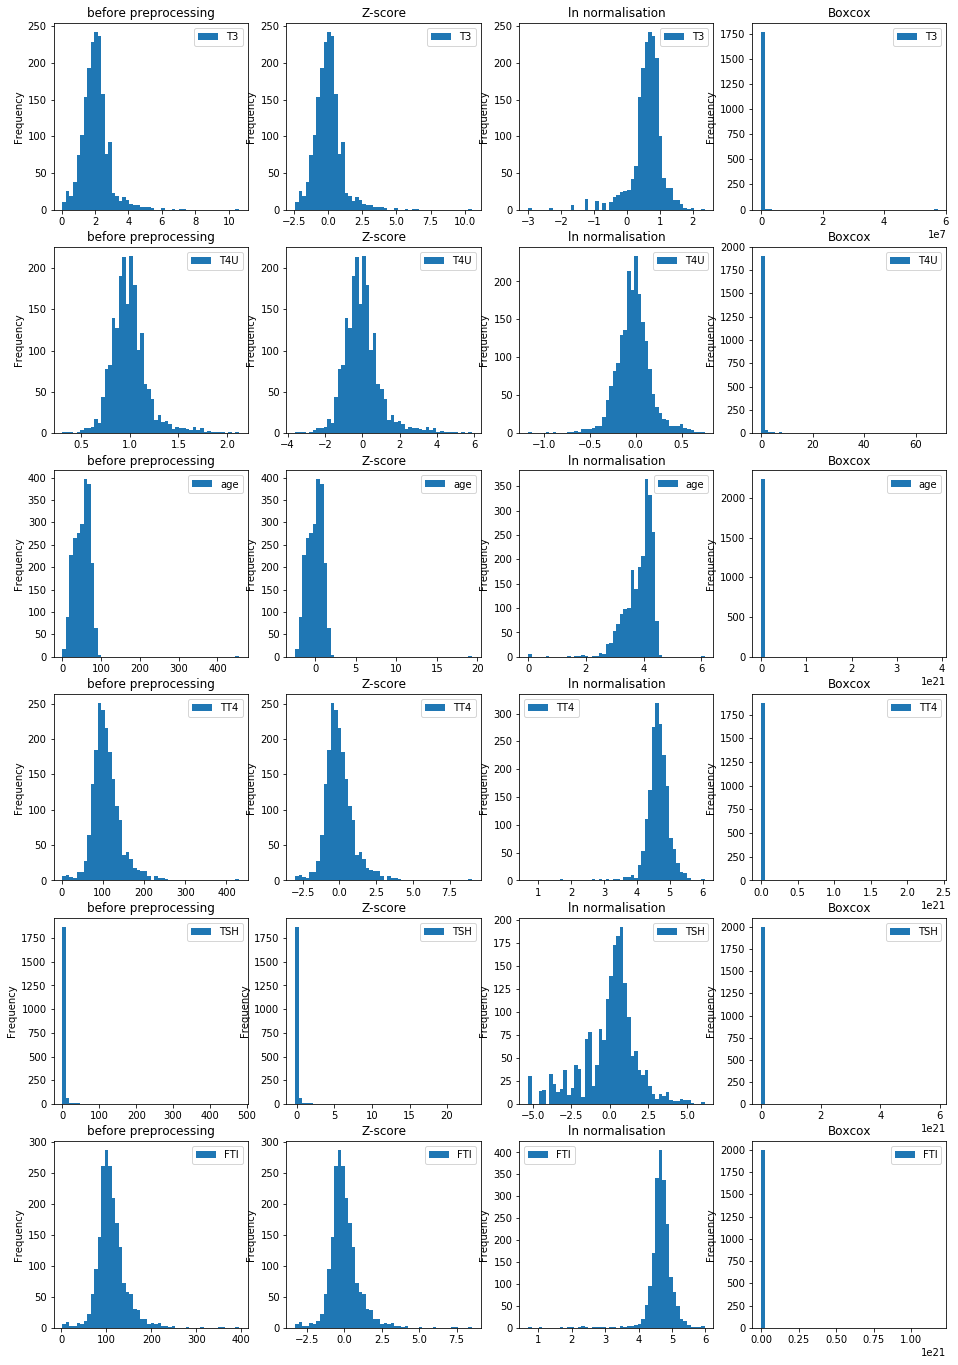

In [84]:
result_train['TT4'] = pd.to_numeric(result_train.TT4, errors='coerce')
result_train['TSH'] = pd.to_numeric(result_train.TSH, errors='coerce')
result_train['FTI'] = pd.to_numeric(result_train.FTI, errors='coerce')


# numeric_columns = ['TT4', 'T4U','TSH', 'T3', 'fnlwgt', 'FTI', 'age']
numeric_columns = ['T3','T4U','age', 'TT4','TSH', 'FTI']
titles = ['before preprocessing', 'Z-score','ln normalisation', 'Boxcox']

ppl = Pipeline([
     ('ZScore',ZScoreNormalization(numeric_columns))
])
ppl2 = Pipeline([
     ('Ln', LogNormalization(numeric_columns))
])
ppl3 = Pipeline([
     ('Boxcox',BoxCoxNormalization(numeric_columns))
])


# test_preprocessing(result_train,numeric_columns,[ppl,ppl2,ppl3],titles=titles, 
#                    sufix=["","_z","_log","_bx"],kind='hist')


test_preprocessing(result_train,numeric_columns,[ppl,ppl2,ppl3],titles=titles, kind='hist')

Normalizacia pomocou Z-score neovplyvnilo rozdelenie, ale posunul najfrekventovanejsiu hodnotu do bodu 0.

Transformacia pomocou prirodzeneho logaritmu sposobila, ze rozdelenie hodnot sa viac priblizilo k normalnemu rozdeleniu. V pripade veku ale graf ostal vyrazne vychyleny.

Boxcox normalizacia obmedzila rozsah hodnot na maly interval (voci povodnemu), ale pre hodnoty, ktore boli z maleho rozsahu presunula vacsinu hodnot velmi blizko k 0, pricom zrejme ostalo par outlierov na pravej strane grafov. 

### porovnanie metod nahradzovanie vychylenych hodnot

Nahradzovanie vychylenych hodnot vykoname na rovnakych atributoch, ako v pripade normalizacie. Normalizaciu vykoname pred pristupmi, kde urcujeme outlierov pomocou percentilov, pouzijeme normalizaciu pomocou prirodzeneho logaritmu. Pri rucne zadanych hraniciach neaplikujeme predom normalizaciu (aby sme vedeli urcit hranicen hodnoty) a pre jednoduchost vychylene hodnoty nahradime tiez 5 a 95 percentilnou hodnotou.

-- Drop outliers for:  ['T3', 'T4U', 'age', 'TT4', 'TSH', 'FTI']
-- Replace outliers with percentile for:  ['T3', 'T4U', 'age', 'TT4', 'TSH', 'FTI']
-- Replace outliers with defined extremes for:  ['T3', 'T4U', 'age', 'TT4', 'TSH', 'FTI']
-- Drop outliers for:  ['T3', 'T4U', 'age', 'TT4', 'TSH', 'FTI']
-- Replace outliers with percentile for:  ['T3', 'T4U', 'age', 'TT4', 'TSH', 'FTI']
-- Replace outliers with defined extremes for:  ['T3', 'T4U', 'age', 'TT4', 'TSH', 'FTI']


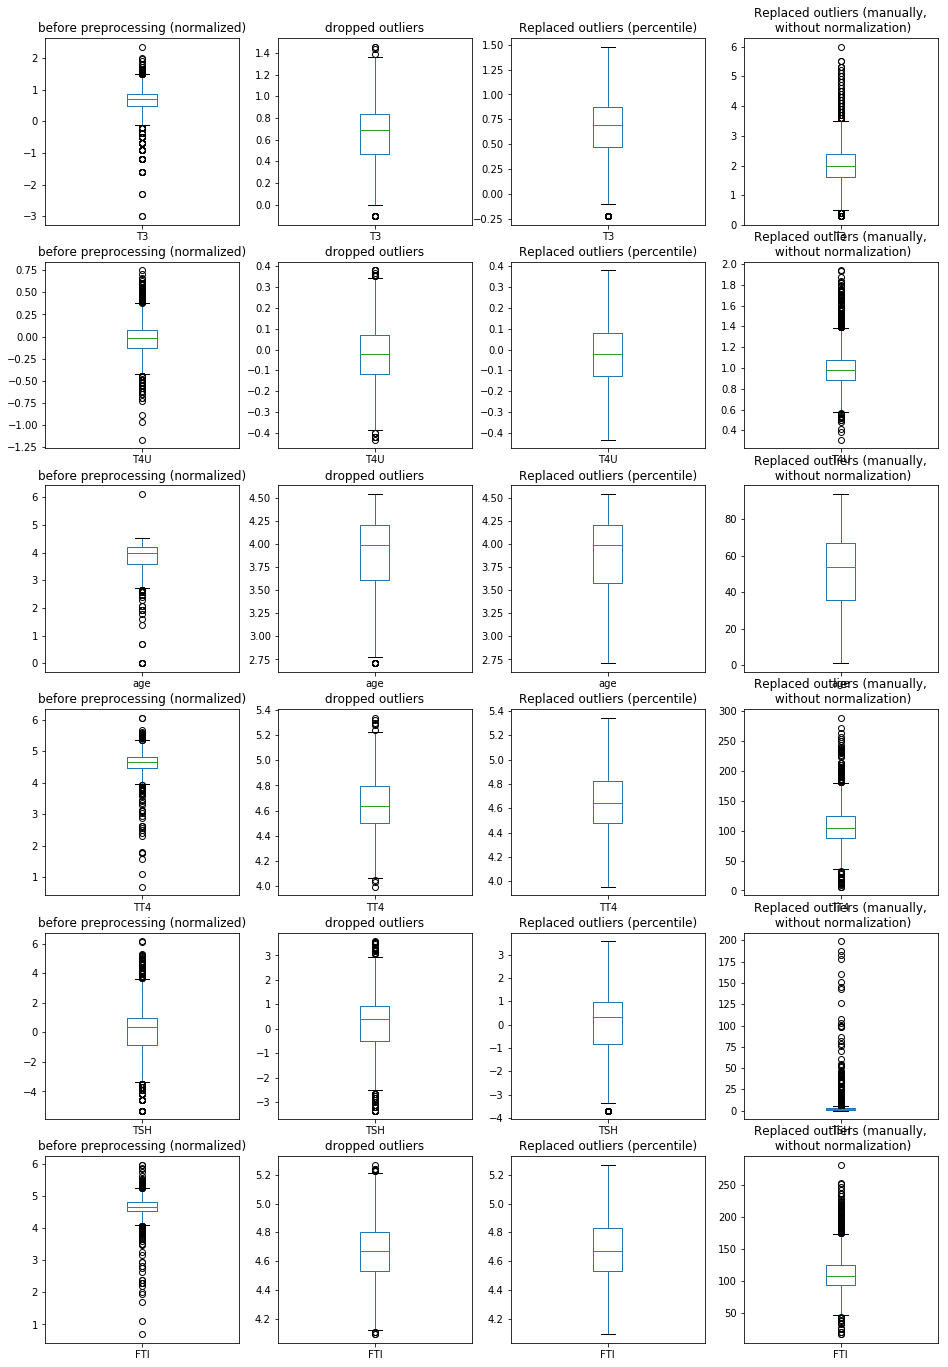

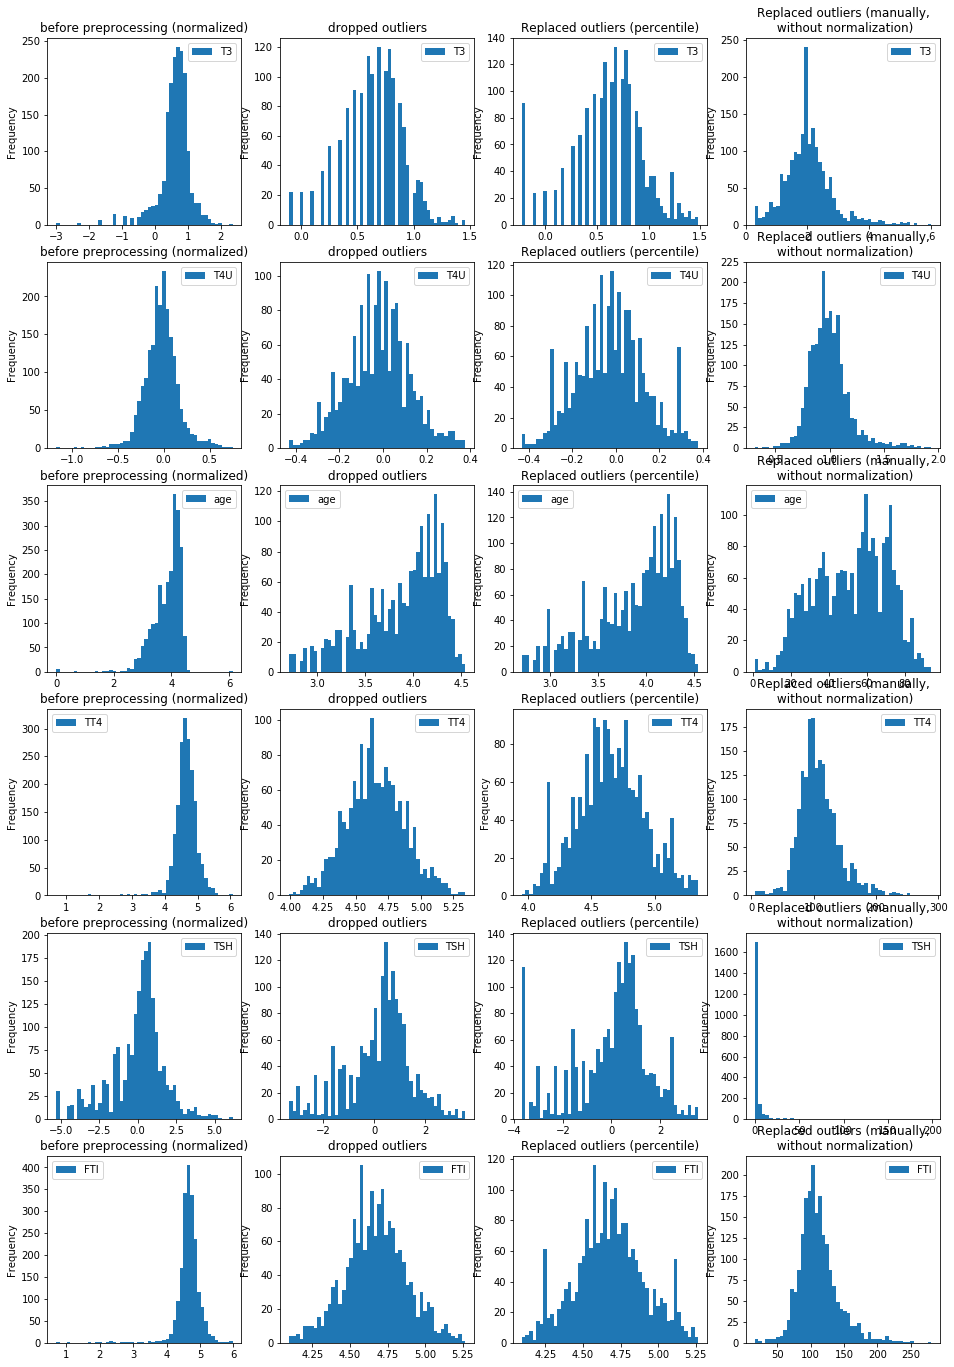

In [85]:
result_train['TT4'] = pd.to_numeric(result_train.TT4, errors='coerce')
result_train['TSH'] = pd.to_numeric(result_train.TSH, errors='coerce')
result_train['FTI'] = pd.to_numeric(result_train.FTI, errors='coerce')


numeric_columns = ['T3','T4U','age', 'TT4','TSH', 'FTI']
titles = ['before preprocessing (normalized)', 'dropped outliers', 
          'Replaced outliers (percentile)', 'Replaced outliers (manually,\n without normalization)']

ppl0 = Pipeline([
     ('Ln', LogNormalization(numeric_columns)),
])

ppl = Pipeline([
     ('Ln', LogNormalization(numeric_columns)),
     ('RemoveExtremes',DropOutliers(numeric_columns))
])
ppl2 = Pipeline([
     ('Ln', LogNormalization(numeric_columns)),
     ('ReplaceExtremes',ReplaceOutliersWithPercentile(numeric_columns))
])

min_extremes = {'T3': 0.3, 'T4U' : 0.3,'fnlwgt': 0, 'age' : 0, 'TT4': 5, 'TSH':0, 'FTI':15}
max_extremes = {'T3': 6, 'T4U' : 2, 'fnlwgt': 1200000, 'age' : 100, 'TT4': 300, 'TSH':200, 'FTI': 300}


ppl3 = Pipeline([
     ('ReplaceKnownOutliers',ReplaceOutliers(numeric_columns, min_extremes, max_extremes))
])


test_preprocessing(result_train,numeric_columns,[ppl,ppl2,ppl3],ppl0=ppl0,titles=titles, )

test_preprocessing(result_train,numeric_columns,[ppl,ppl2,ppl3],ppl0=ppl0,titles=titles, 
                   kind='hist')

Odstranenie outlierov na zaklade medzikvartiloveho rozpatia sice zmensilo pocet hodnot, ktore sa javia ako outlieri, ale odstrenenim riadkov sa mohli stratit dolezite informacie, ktore mohli pomoct pri predikcii.

Nahradenim outlierov (na zaklade percentilu) za 5 a 95 percentilnu hodnotu sme dosiahli tiez rozdelenie blizsie normalnemu, ale niektore z hodnot, ktore sa javia, ako vychylene v skutocnosti mozu byt validne, len menej caste pripady, ktore by mohli pomoct pri predikcii a takto ich stracame. Zaroven v niektorych pripadoch vyrazne narastol pocet hodnot pri 5 a 95 percentiloch, co sa uz nepodoba na normalne rozdelenie.

Problem pri otazke, ci su merania oznacene automaticky ako extrem skutocne validne, by mohol vyriesit pristup, kde manulane nastavime, ktore hodnoty su vychylene/neralne, ktore nahradime. (Napriklad vek obmedzit od 0 do 100/120 rokov, kedze je velmi nepravdepodobne, ze by clovek zil dlhsie), pre toto riesenie nam ale chyba vacsia znalost domeny, nevieme urcit, ktore hodnoty proteinov su este validne, a ktore uz nie. Vieme pomerne lahko na internete najst rozsah hodnot, co sa pocita este za "normalny", ale je tazke urcit, ze napriklad v pripade chorych ludi aky rozsah tieto hodnoty mozu mat, pricom budu stale validne.

### porovnanie metod doplnania hodnot

#### ciselne atributy
porovname strategie doplnania ciselnych atributov pomocu medianu, priemeru a pomocou linearnej regresie

Pre overenie doplnania pouzijeme stlpce TT3, T4U, TSH, T3, FTI, ktore sa ukazali pocas analyzy, ako napomocne. Atribut fnlwgt nema chybajuce hodnoty. Pred doplnanim hodnot ich znormalizujeme pomocou prirodzeneho logaritmu.

pocet hodnot: 1465/2237, TT4(neg_mean_squared_error): -5.698683269425478e-05
pocet hodnot: 1465/2237, T4U(neg_mean_squared_error): -5.698143572575978e-05
pocet hodnot: 1465/2237, TSH(neg_mean_squared_error): -2.3004239758457223
pocet hodnot: 1465/2237, T3(neg_mean_squared_error): -0.12675976415281
pocet hodnot: 1465/2237, FTI(neg_mean_squared_error): -5.71775901786797e-05
transform  ['TT4', 'T4U', 'TSH', 'T3', 'FTI']
pocet predikovanych pre  TT4 :  360
pocet predikovanych pre  T4U :  235
pocet predikovanych pre  TSH :  232
pocet predikovanych pre  T3 :  468
pocet predikovanych pre  FTI :  235


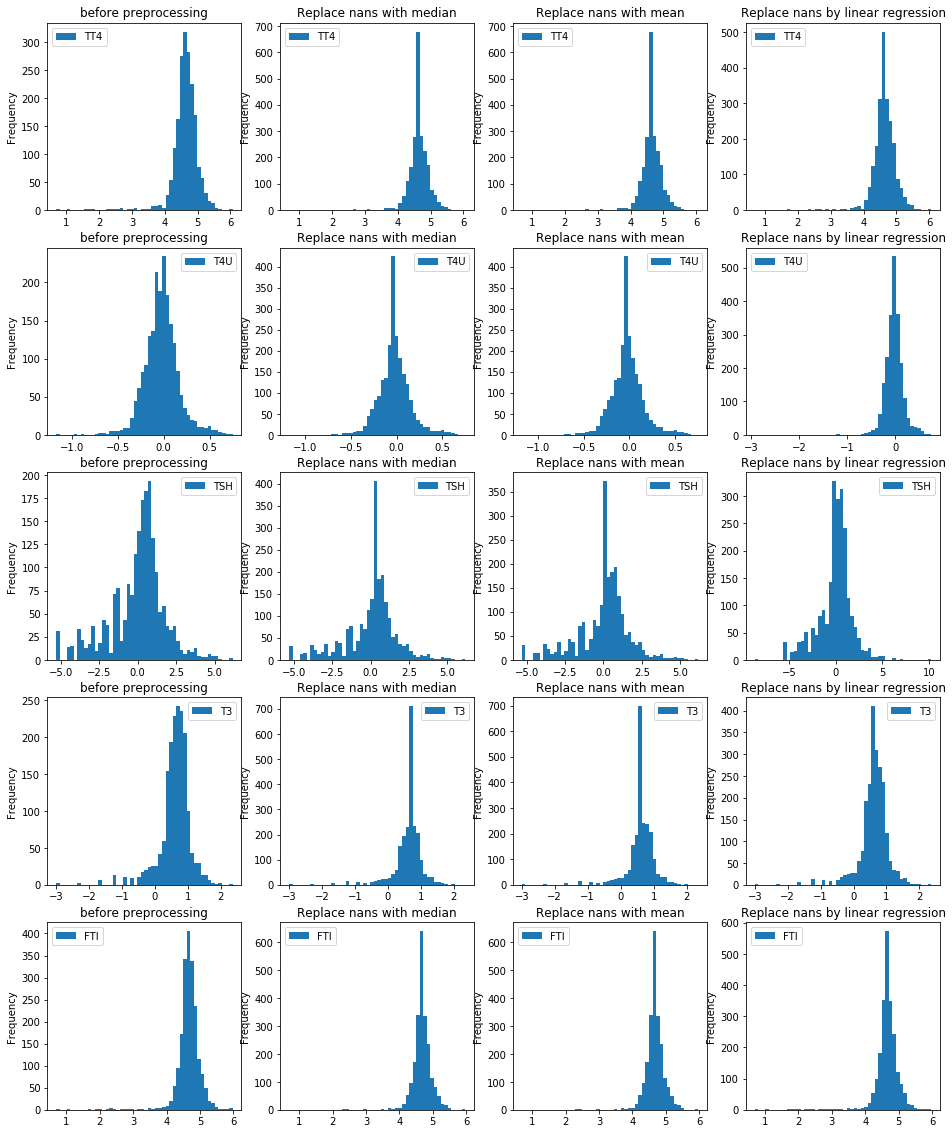

In [86]:
result_train['TT4'] = pd.to_numeric(result_train.TT4, errors='coerce')
result_train['TSH'] = pd.to_numeric(result_train.TSH, errors='coerce')
result_train['FTI'] = pd.to_numeric(result_train.FTI, errors='coerce')


numeric_columns = ['TT4', 'T4U','TSH', 'T3', 'FTI']
# numeric_columns = ['T3','T4U', 'TT4','TSH', 'FTI']
titles = ['before preprocessing', 'Replace nans with median', 'Replace nans with mean',
          'Replace nans by linear regression']

model = LinearRegression()

ppl0= Pipeline([
     ('Ln', LogNormalization(numeric_columns)),
])

ppl = Pipeline([
     ('Ln', LogNormalization(numeric_columns)),
     ('ReplaceNans',ReplaceNans(numeric_columns)),
])
ppl2 = Pipeline([
     ('Ln', LogNormalization(numeric_columns)),
     ('ReplaceNans',ReplaceNans(numeric_columns, func_type='mean')),
])
ppl3 = Pipeline([
     ('Ln', LogNormalization(numeric_columns)),
    ('ReplaceNansWithModel',ReplaceNanWithModel(numeric_columns,model,numeric_columns)),
])


test_preprocessing(result_train,numeric_columns,[ppl, ppl2,ppl3], titles=titles,
                   kind='hist', ppl0=ppl0)

Doplnanie pomocou medianu a priemeru vyrazne zvisilo pocet hodnot v strede rozdelenia, pri vacsom pocte chybajucich hodnot pravdepodobne tento pristup nie je uplne vhodny.

Doplnanie linearnou regresiou vacsinu hodnot doplnila tiez najfrekventovanejsiou hodnotou, ale zaroven doplnila aj hodnoty z vacsiho rozsahu.

#### kategoricke atributy

porovname strategie doplnanie kategorickych atributov pomocou najfrekventovanejsej hodnoty a pomocou modelu RandomForest.

Pre porovnanie pouzijeme X_train dataset, kde su uz extrahovane hodnoty z medical info a True/False hodnoty zredukovane na 3 hondoty (t,f,nan)

In [70]:
categorical_columns = ['marital-status','education','native-country','occupation',
                       'race','referral source','relationship','sex','sick','tumor','workclass',
                       'pregnant',	'thyroid surgery', 'I131 treatment',  'psych', 'query hypothyroid']

X_train['sex'].isna().value_counts()

False    2237
Name: sex, dtype: int64

In [71]:
for col in categorical_columns:
    print(col, X_train[col].unique())

marital-status [' Divorced' ' Never-married' ' Separated' ' Married-civ-spouse'
 ' Widowed' ' Married-spouse-absent']
education [' HS-grad' ' Some-college' ' Masters' ' Bachelors' ' Doctorate'
 ' Assoc-voc' ' 11th' ' Prof-school' ' 12th' ' Assoc-acdm' ' 9th'
 ' 7th-8th' ' Preschool' ' 5th-6th' ' 10th' ' 1st-4th']
native-country [' United-States' ' ?' ' Cuba' ' Mexico' ' Columbia' ' Italy' ' Iran'
 ' Dominican-Republic' ' El-Salvador' ' Nicaragua' ' Philippines'
 ' England' ' Germany' ' Poland' ' Jamaica' ' Guatemala' ' Honduras'
 ' China' ' Puerto-Rico' ' Taiwan' ' Canada' ' Japan' ' Hong' ' France'
 ' Portugal' ' Thailand' ' South' ' Haiti' ' Outlying-US(Guam-USVI-etc)'
 ' Peru' ' Vietnam' ' Ecuador' ' Greece' ' Scotland' ' Ireland' ' Laos'
 ' India' nan]
occupation [' Adm-clerical' ' Exec-managerial' ' Prof-specialty' ' Handlers-cleaners'
 ' Machine-op-inspct' ' ?' ' Other-service' ' Sales' ' Craft-repair'
 ' Tech-support' ' Protective-serv' ' Transport-moving' ' Farming-fishing'
 ' 

Stlpce: native-country, occupation, sex a workclass obsahuju hodnotu '?', co by sme mohli pokladat za Nan

Stlpec tumor obsahuje hodnoty Nan. Ostatne kategoricke atributy maju hodnoty vyplnene. Atribut native-country ma na zaklade analyzy obrovsku prevahu jedna hodnota a ostatne hodnoty sa vyskytuju len obcasne, preto nie je uplne vhodny na predikciu choroby a mozeme ju vynechat z porovnavania

pocet hodnot: 2000/2237, occupation(accuracy score): 0.2635496294922064
pocet hodnot: 2000/2237, sex(accuracy score): 0.8050082781767387


C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


pocet hodnot: 2000/2237, workclass(accuracy score): 0.7500068767709601
pocet hodnot: 2000/2237, tumor(accuracy score): 0.9745023750148439
transform  ['occupation', 'sex', 'workclass', 'tumor']
pocet predikovanych pre  occupation :  151
pocet predikovanych pre  sex :  88
pocet predikovanych pre  workclass :  152
pocet predikovanych pre  tumor :  1


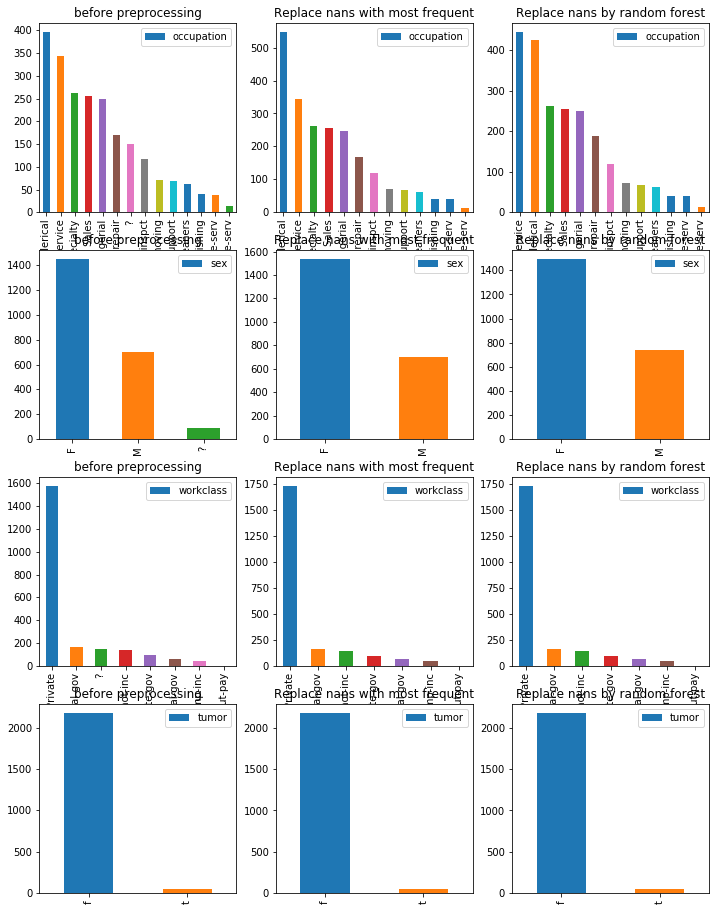

In [72]:
categorical_columns = ['occupation','sex','workclass', 'tumor']

titles = ['before preprocessing', 'Replace nans with most frequent', 'Replace nans by random forest',]

encoder = ce.OneHotEncoder()

ppl1 = Pipeline([
    ('FindNans', StringReplacer(categorical_columns, '?', np.NaN)),
    ('ReplaceWithMostFrequent', ReplaceMostFrequent(col_names=categorical_columns))
])

ppl2 = Pipeline([
    ('FindNans', StringReplacer(categorical_columns, '?', np.NaN)),
    ('ReplaceWithModelOccupation', ReplaceCategoryNanWithModel(['occupation','sex','workclass','tumor'],
                                                               ['occupation','sex','workclass', 'tumor', 'marital-status'],
                                                     RandomForestClassifier(n_estimators = 100,
                                                                            max_depth = 12, random_state = 8), 
                                                     encoder)),

])


test_preprocessing(X_train,categorical_columns,[ppl1,ppl2], titles=titles,kind='bar')

V pripade occupation random forest rozdelil vacsinu nan hodnot do dvoch najfrekventovanejsich kategorii, jej nizka uspesnost (accuracy score 26%) moze byt sposobena velkym mnozstvom kategorii.

V pripade ostatnych atributov bolo podstatne menej Nan hodnot, preto sa mohli natrenovat aj presnejsie modely

### Vysledne predspracovanie a nasledna analyza

Vo výslednej pipeline predspracovania, využijeme všetky metody upravy dat ktore boli diskutovane, a ktore sme uznali ako najvhodnejsie pre nas dataset a konkretne atributy datasetu.  


In [88]:
true_false_cols = ['on antithyroid medication','query hyperthyroid','FTI measured',
                   'lithium','tumor','sick','TT4 measured','goitre','hypopituitary',
                   'TBG measured','TSH measured', 'T3 measured', 'on thyroxine',
                   'query on thyroxine', 'psych', 'I131 treatment', 'query hypothyroid',
                   'T4U measured', 'thyroid surgery', 'pregnant']

numeric_columns = ['TT4', 'T4U','TSH', 'T3', 'FTI','age']

all_numeric_columns = ['FTI', 'T3', 'T4U',  'TSH', 'TT4', 'age', 'capital-gain',
                       'capital-loss', 'education-num', 'fnlwgt', 'hours-per-week']

categorical_columns = ['occupation','sex','workclass', 'tumor']

all_categorical_columns = ['marital-status','education','native-country','occupation',
                       'race','referral source','relationship','sex','sick','tumor','workclass',
                       'pregnant',	'thyroid surgery', 'I131 treatment',  'psych', 'query hypothyroid']


encoder = ce.OneHotEncoder()
model_numeric = LinearRegression()
model_categorical = RandomForestClassifier(n_estimators = 100,
                    max_depth = 12, random_state = 8)


ppl = Pipeline([
    
    ('ExtraxtMedicalInfo',Extraction('medical_info')),
    ('AllNumObjectstoNumeric', ObjectToNumeric(all_numeric_columns)),
    
    
    ('ReplaceFalseCorrect',StringReplacer(true_false_cols,'f','f')),
    ('ReplaceTrueCorrect',StringReplacer(true_false_cols,'t','t')),
    
    ('ReplaceClassNegative',StringReplacer(['class'],'negativ','negative')),
    ('ReplaceClassIncreased',StringReplacer(['class'],'increase','increased')),
    ('ReplaceClassDecreased',StringReplacer(['class'],'decrease','decreased')),
    
    ('FindNans', StringReplacer(all_categorical_columns, '?', np.NaN)),
    
    # normalizacia
    ('Ln', LogNormalization(numeric_columns)),
    # odstranenie outlierov
    ('ReplaceExtremes',ReplaceOutliersWithPercentile(numeric_columns)),
    # doplnenie prazdnych hodnot modelmi
    ('ReplaceNumericNansWithModel',ReplaceNanWithModel(numeric_columns, LinearRegression(), numeric_columns)),
    ('ReplaceCategoricalNansWithModel', ReplaceCategoryNanWithModel(['occupation','sex','workclass','tumor'],
                                                               ['occupation','sex','workclass', 'tumor', 'marital-status'],
                                                                model_categorical, encoder)),
    # doplnenie prazdnych hodnot v pripade velkeho poctu kategorii, ktore predpokladame, ze z pohladu analyzy nezohravaju az taku dolezitu ulohu
    ('ReplaceWithMostFrequent', ReplaceMostFrequent(col_names=['native-country','FTI measured', 'relationship',
                                                               'query hypothyroid','hours-per-week']))
    
])

model =ppl.fit(result_train)
X_train = ppl.transform(result_train)

-- Extraction of  medical_info
-- Transform object to numeric for:  ['FTI', 'T3', 'T4U', 'TSH', 'TT4', 'age', 'capital-gain', 'capital-loss', 'education-num', 'fnlwgt', 'hours-per-week']
-- Replacing: ** f ** to:  f  , for:  ['on antithyroid medication', 'query hyperthyroid', 'FTI measured', 'lithium', 'tumor', 'sick', 'TT4 measured', 'goitre', 'hypopituitary', 'TBG measured', 'TSH measured', 'T3 measured', 'on thyroxine', 'query on thyroxine', 'psych', 'I131 treatment', 'query hypothyroid', 'T4U measured', 'thyroid surgery', 'pregnant']
-- Replacing: ** t ** to:  t  , for:  ['on antithyroid medication', 'query hyperthyroid', 'FTI measured', 'lithium', 'tumor', 'sick', 'TT4 measured', 'goitre', 'hypopituitary', 'TBG measured', 'TSH measured', 'T3 measured', 'on thyroxine', 'query on thyroxine', 'psych', 'I131 treatment', 'query hypothyroid', 'T4U measured', 'thyroid surgery', 'pregnant']
-- Replacing: ** negativ ** to:  negative  , for:  ['class']
-- Replacing: ** increase ** to:  incr

/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


pocet hodnot: 2000/2237, workclass(accuracy score): 0.7500068767709601
pocet hodnot: 2000/2237, tumor(accuracy score): 0.9745023750148439
transform  ['occupation', 'sex', 'workclass', 'tumor']
pocet predikovanych pre  occupation :  151
pocet predikovanych pre  sex :  88
pocet predikovanych pre  workclass :  152
pocet predikovanych pre  tumor :  1
transform  ['TT4', 'T4U', 'TSH', 'T3', 'FTI', 'age']
pocet predikovanych pre  TT4 :  360
pocet predikovanych pre  T4U :  235
pocet predikovanych pre  TSH :  232
pocet predikovanych pre  T3 :  468
pocet predikovanych pre  FTI :  235
pocet predikovanych pre  age :  1
transform  ['occupation', 'sex', 'workclass', 'tumor']
pocet predikovanych pre  occupation :  151
pocet predikovanych pre  sex :  88
pocet predikovanych pre  workclass :  152
pocet predikovanych pre  tumor :  1


### Doplnenie NaN hodnot

V predspracovaní sa nam podarilo odstranit NaN hodnoty pre aatributy ktore povazujeme potrebne pre nasledne trenovanie modelov. Atribut 'Education-num' nie je doplneny z dovodu ze sa zhoduje s atributom 'education', kde stačí urobit ordinary encoding.

In [98]:
X_train.head()

,FTI,FTI measured,T3,T4U,TBG,TBG measured,TSH,TT4,TT4 measured,Unnamed: 0_x,Unnamed: 0_y,address,age,capital-gain,capital-loss,class,date_of_birth,education,education-num,fnlwgt,goitre,hours-per-week,hypopituitary,lithium,marital-status,medical_info,name,native-country,occupation,on antithyroid medication,query hyperthyroid,race,referral source,relationship,sex,sick,tumor,workclass,on thyroxine,psych,query on thyroxine,T3 measured,pregnant,TSH measured,I131 treatment,T4U measured,thyroid surgery,query hypothyroid
0,4.532599,t,-0.105361,0.104360,?,f,2.116256,4.634729,t,0,1425,"11818 Lori Crossing Apt. 802\nPughstad, DC 78165",3.891820,0.0,0.0,negative,69-04-28,HS-grad,9.0,108997.0,f,40.0,f,f,Divorced,"{'query hypothyroid':'t','T4U measured':'t','p...",Edith Boudreaux,United-States,Adm-clerical,f,f,White,SVI,Unmarried,F,f,f,Private,f,f,f,t,f,t,f,t,f,t
1,4.919981,t,0.095310,-0.198451,?,f,1.131402,4.718499,t,1,458,"PSC 4657, Box 5446\nAPO AP 58412",4.356709,0.0,0.0,negative,1940-01-23,Some-college,10.0,424012.0,f,40.0,f,f,Divorced,"{'query hypothyroid':'f','T4U measured':'t','p...",Janet Washington,United-States,Exec-managerial,f,f,White,SVHD,Not-in-family,F,f,f,Federal-gov,f,f,f,t,f,t,f,t,f,f
2,4.890349,t,0.633935,-0.162519,?,f,-3.352407,4.727388,t,2,1875,Unit 9759 Box 9470\nDPO AP 45549,4.174387,0.0,0.0,negative,1953-06-23,Masters,NaN,143046.0,f,40.0,f,f,Never-married,"{'query hypothyroid':'f','T4U measured':'t','p...",Margaret Chabot,United-States,Adm-clerical,f,f,White,other,Not-in-family,F,f,f,Private,f,f,f,f,f,t,f,t,f,f
3,4.727388,t,0.741937,-0.139262,?,f,-2.525729,4.595120,t,3,56,"137 Lewis Flat Suite 762\nWest Elizabeth, AL 3...",3.526361,0.0,0.0,negative,1984-03-08,Bachelors,NaN,183390.0,f,40.0,f,f,Separated,"{'query hypothyroid':'f','T4U measured':'t','p...",Terry Terry,United-States,Prof-specialty,f,t,White,other,Not-in-family,M,f,f,Local-gov,f,f,f,t,f,t,f,t,f,f
4,4.976734,t,0.741937,0.131028,?,f,0.470004,5.099866,t,4,599,"995 Frank Stravenue\nSouth Matthewport, TX 81402",4.043051,0.0,0.0,negative,1961-09-16,Bachelors,13.0,106935.0,f,45.0,f,f,Married-civ-spouse,"{'query hypothyroid':'f','T4U measured':'t','p...",Stephen Lalk,United-States,Exec-managerial,f,f,White,SVI,Husband,M,f,f,Private,f,f,f,t,f,t,f,t,f,f


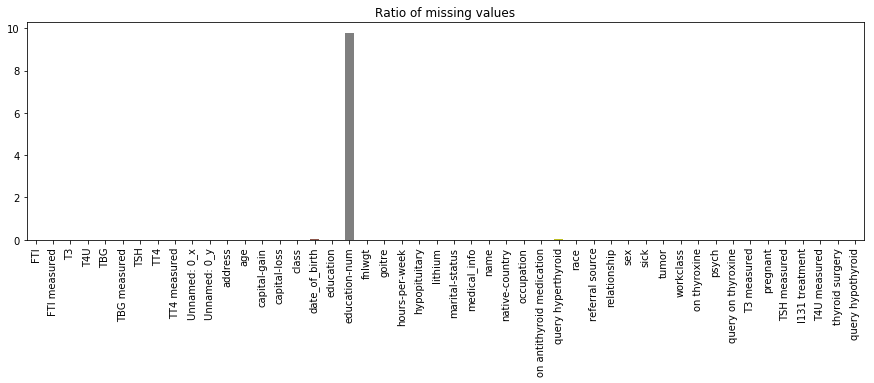

In [89]:
plt.figure(figsize=(15,4))
X_train.isna().sum().map(lambda x: (x / other_train.shape[0])* 100).plot(kind='bar',title = 'Ratio of missing values')

#### Normalizovane numericke atributy

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  w

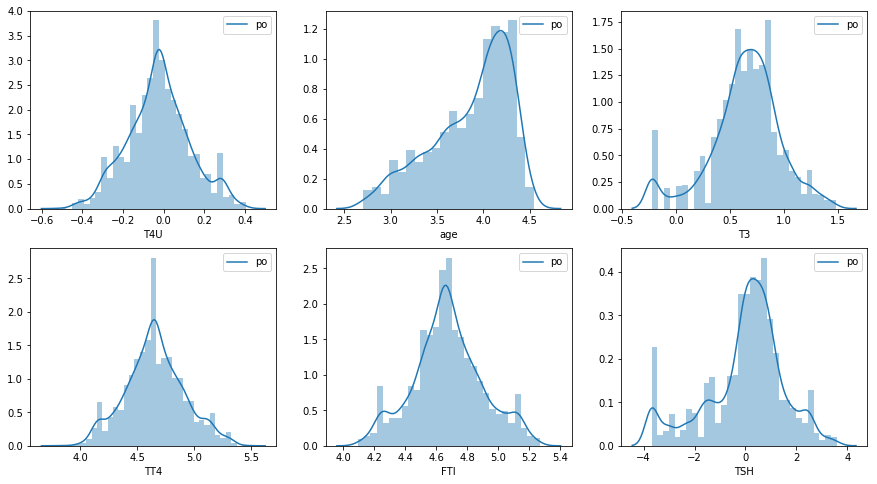

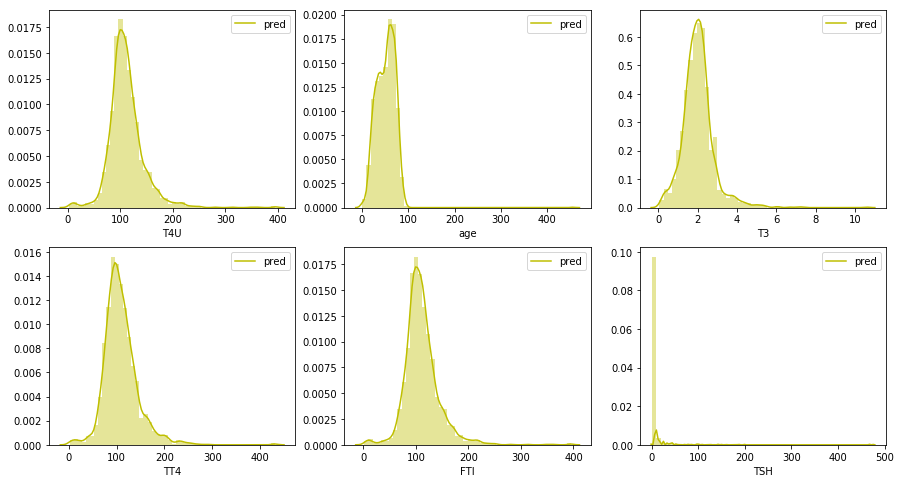

In [121]:
fig, axs = plt.subplots(2,3 ,squeeze = False, 
                            figsize = (15, 8))
sns.distplot(X_train['T4U'],ax = axs[0][0], kde_kws={ "label": "po"})
sns.distplot(X_train['age'],ax = axs[0][1], kde_kws={ "label": "po"})
sns.distplot(X_train['T3'],ax = axs[0][2], kde_kws={ "label": "po"})
sns.distplot(X_train['TT4'],ax = axs[1][0], kde_kws={ "label": "po"})
sns.distplot(X_train['FTI'],ax = axs[1][1], kde_kws={ "label": "po"})
sns.distplot(X_train['TSH'],ax = axs[1][2], kde_kws={ "label": "po"})

result_train['TT4'] = pd.to_numeric(result_train.TT4, errors='coerce')
result_train['TSH'] = pd.to_numeric(result_train.TSH, errors='coerce')
result_train['FTI'] = pd.to_numeric(result_train.FTI, errors='coerce')
result_train['T4U'] = pd.to_numeric(result_train.FTI, errors='coerce')

fig2, axs1 = plt.subplots(2,3 ,squeeze = False, 
                            figsize = (15, 8))
sns.distplot(result_train['T4U'].dropna(),ax = axs1[0][0],color ='y', kde_kws={ "label": "pred"})
sns.distplot(result_train['age'].dropna(),ax = axs1[0][1],color ='y', kde_kws={ "label": "pred"})
sns.distplot(result_train['T3'].dropna(),ax = axs1[0][2],color ='y', kde_kws={ "label": "pred"})
sns.distplot(result_train['TT4'].dropna(),ax = axs1[1][0],color ='y', kde_kws={ "label": "pred"})
sns.distplot(result_train['FTI'].dropna(),ax = axs1[1][1],color ='y', kde_kws={ "label": "pred"})
sns.distplot(result_train['TSH'].dropna(),ax = axs1[1][2],color ='y', kde_kws={ "label": "pred"})

Ani po spracovani nemaju ciselne atributy rozdelenie uplne podobajuce sa na normalne, ale rozsah hodnot sa vyrazne zmensil a odstranili sa outlieri, co ulahcuje dalsiu pracu s tymi atributmi. 

## Zhrnutie

* V časti predspracovania udajov sme ako prvé spojili dva naše datasety, kde bol vyuzity ako unifikator spojenie atributov 'name' a 'address'. Vysledkom bol dataset ktory obsahoval zjednotenie tychto dvoch datasetov. 
* Následne sme odstranili dulikáty pri čom sme zanechali všetky potrebne informacie.
* Z atributu 'medical info' sme extrahovali vsetky dalsie atributy a obohatili sme nimi nas dataset.
* Opravili sme hodnoty na jednotnu formu, napr. boolean atributy len na **'t' a 'f'** alebo atribut **'class' na (negative, increased,decresed)**, či **? na Nan**.
* Upravy hranicnych hodnot pomocou **medianu, manualne stanovenie hranic, odstranenie outlierov**.
* Normalizacia numerickych hodnot **BoxCox normalizacia, Z score a Logaritmicka normalizacia**.
* Škalovanie hodnot.
* Doplnanie NaN hodnot pomocou **modelov**, **najcastejsou hodnotou, medianom a priemerom**.